<a id=TOC></a>  
__Unit 4 Practical Session Demo: Linear Regression & Gradient Descent__  
__Prepared for:__  `Data Analytics and Machine Learning at Scale `  
__By:__  `Dr. James Shanahan`

# Unit 04 Linear Regression plus practical tips


## Learning objectives
1. Review Simple Linear regression via gradient descent (and brute force)
* To deal with missing data
* Handle categorical input and output features
* Partitioning data into train, test etc.
* Feature scaling
* Feature selection
* Feature importance

## Reading material: 

* Chapter 4 in the following book provides a great parallel to this notebook (especially for the second half of this notebook.
  * Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017



In [98]:
import numpy as np
x = np.arange(15).reshape(-1, 3)
x[0:3]  #take first three rows of data

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

<a id=intro></a>
# Introduction to Linear Regression (via GD)

In this demo, we'll use Linear Regression as a simple example in order to explore key topics related to distributed learning of parametric models. Broadly speaking, the supervised learning of a parametric model can be split into to two components:
1. **Prediction Task**: Given an input vector, return an output value.
2. **Optimization Task (a.k.a. Learning)**: Given a strategy for making a prediction, return the specific parameters which guarantee the optimal prediction.


OK, Let's start with a quick review of some notation you will have seen previously. 

## Notation Review

Linear Regression tackles the __prediction task__ by assuming that we can compute our output variable, $y$, using a linear combination of our input variables. That is we assume there exist a set of **weights**, $\mathbf{w}$, and a **bias** term, $\mathbf{b}$, such that for any input $\mathbf{x}_j \in \mathbb{R}^m$:

\begin{equation}\tag{1.1}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}

In vector notation, this can be written:

\begin{equation}
y_j = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}

Of course, this perfect linear relationship never holds over a whole dataset **$X$**, so Linear Regression attempts to fit (i.e. **learn**) the best line (in 1 dimension) or hyperplane (in 2 or more dimensions) to the data.  In the case of **ordinary least squares (OLS)** linear regression, best fit is defined as minimizing the Euclidean distances of each point in the dataset to the line or hyperplane.  These distances are often referred to as **residuals**. 

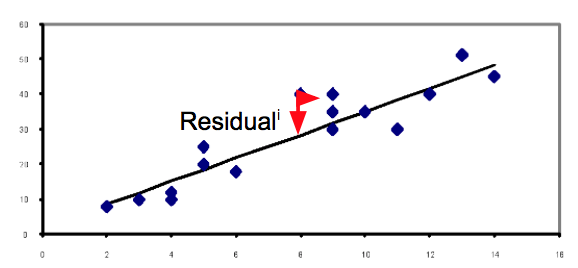

In [100]:
from IPython.display import Image
Image(filename="residual.png", width="400", height="200")

The calculation of the average residual (a.k.a.**mean squared error, MSE**) over our test or training set allows us to measure how good a fit we've achieved. We call this function the **loss** or **objective** function because our goal in the **optimization task** is to find the parameters which minimize it.

\begin{equation}\tag{1.2}
f(\mathbf{w}, b) = \frac{1}{n}\sum_{j=1}^{n}\left[ (\mathbf{w}^T\mathbf{x}_j + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
\end{equation}

For convenience, we sometimes choose to think of the bias $b$ as weight $w_{m+1}$. To operationalize this, we'll _augment_ our input vectors by setting $x_{m+1}=1$. This gives us a simpler way to write the loss function:
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

Machine Learning packages like `sklearn` and `tensorflow` take this one step further by representing the entire training set in a single matrix were each row is an input vector and each column represents a feature:
$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

\begin{equation}\tag{1.4}
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
\end{equation}

As you see here, it is customary to write loss as a function of the parameters $\theta$ (or equivalently $\mathbf{w}$ and $b$). However it is important to note that the MSE loss depends on both the parameters/weights  _and_ the data $X$, we'll talk more about that later.

> __DISCUSSION QUESTIONS:__ 
* _In equation 1.1 what do $x_{ji}$, $w_i$, and $\mathbf{w}$ each represent?_  
* _If we were computing loss over a really large data set what might be the arguments in favor / against using the augmented version of the loss function calculation?_

## Notebook Set Up

In [101]:
# install seaborn if you haven't already
!pip install seaborn

In [102]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

__IMPORTANT!__ Before we begin, please run the cells in the [Appendix](#Appendix) to generate the supporting files & helper code that we'll use in our demos. When you're done, return here to get started.

In [103]:
# import helper modules
import helperFunc
import linRegFunc

# OPTIONAL - uncomment to print helper file docstrings
print (helperFunc.__doc__)
#print linRegFunc.__doc__


This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)




<a id=small_ex></a>
## A Small Example


We'll start with a small example of 5 2-D points:

In [104]:
%%writefile fivePoints.csv
1,2
3,4
5,5
4,3
2,3

Overwriting fivePoints.csv


In [105]:
# load data from file
points = np.genfromtxt("fivePoints.csv", delimiter=',')

Here's what they look like next to a the simplest possible linear model:  $ y = x$

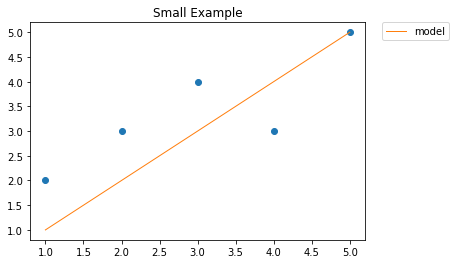

In [106]:
# easy plotting with a helper function
helperFunc.plot2DModels(points, [[1,0]],['model'], title = 'Small Example')

Looks reasonable, but its hard to gauge exactly how good a fit we have just by looking.

> __A TASK FOR YOU:__ Fill in the calculations below to compute the "Training Loss" for our data. These are easy and intuitive calculations that you will know from long-ago math classes... but instead of relying on your visual intuition, challenge yourself to think through these numbers in the context of our matrix equation for loss. Here it is again for your reference:
\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}


The parameter vector $\theta$ for our initial line $y=x$ is: 
$ \begin{bmatrix} ? \ \quad ? \ \end{bmatrix}$
         
The (augmented) data points $x_j$ are:
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$

Our loss calculations will be:

|$i$  | $y_i$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_i$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2$ |
|:---:|:-----:|:----------------:|:------------------------:|
|     | true y   |   predicted y   |  squared residual       |
| 1   |       |                  |             |
| 2   |       |                  |    |
| 3   |       |                  |    |
| 4   |       |                  |    |
| 5   |       |                  |    |

 The training loss $f(\boldsymbol{\theta})$ for this data and these weights is: _______
 

In [107]:
# Run this cell to confirm your Hand Calculations
X = helperFunc.augment(points)[:,:-1]
y = points[:,-1]
print ("Loss:", linRegFunc.OLSLoss(X, y,[1,0]))

Loss: 0.8


 > __DISCUSSION QUESTIONS:__ 
 * _What parts of this computation could be parallelized? What, if any, aggregation has to happen at the end?_ 
 * _What key-value format, partitioning, sorting would help? Could you use a combiner?_ 
 * _In addition to the data stream, what other information would your map or reduce tasks need access to?_ 

<a id=demo1></a>
## Demo: Random Parameter Search.
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

Ok, so we know the model looks ok and we know its loss is $0.8$ but is that any good? A naive approach to "learning" a Linear Model might be to randomly generate a few more models and then pick the model with the lowest loss. Let's try it.

Best Random Model: [0, 1], Loss: 0.8


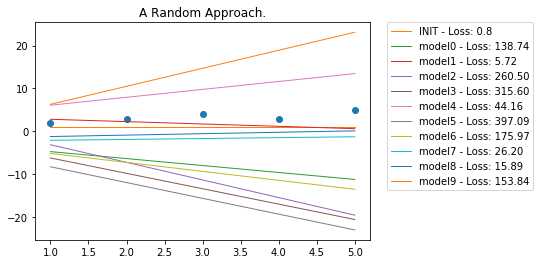

In [108]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
NUM_MODELS = 10
PARAM_RANGE = [-5,5]

#################### Random Search Demo ####################
# Load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

# "Training"
models = [[0,1]]
names = ["INIT - Loss: 0.8"]
best = {'loss':0.8, 'W': [0,1]}
for idx in range(NUM_MODELS):
    # initialize a random weight vector w/ values in specified range
    W = np.random.uniform(PARAM_RANGE[0],PARAM_RANGE[1], size=(2))
    # compute loss & store for plotting
    loss = linRegFunc.OLSLoss(X, y, W)
    models.append(W)
    names.append("model%s - Loss: %.2f" % (idx, loss))
    # track best model
    if loss < best['loss']:
        best['loss'] = loss
        best['W'] = W
        
# Display Results
print ("Best Random Model: %s, Loss: %s" % (best["W"], best["loss"]))
helperFunc.plot2DModels(points, models, names, "A Random Approach.")

So, that was pretty poor. One idea would be to run a lot more iterations.

> __DISCUSSION QUESTION:__ _To what extent could parallelization help us redeem this approach? What exactly would you parallelize?_

<a id=demo2></a>
## Demo: Systematic Brute Force.
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

For obvious reasons a more systematic approach is desirable. Instead of randomly guessing, lets use what we know to search an appropriate section of the the model space.

We can tell from the data that the linear model should probably have a fairly shallow positive slope and a positive intercept between 0 and 2. So lets initialize every possible combination of weights in that range up to a granularity of, say $0.2$, and compute the loss for each one.

Searched 100 models...
Best model: [ 0.6  1.6], Loss: 0.32


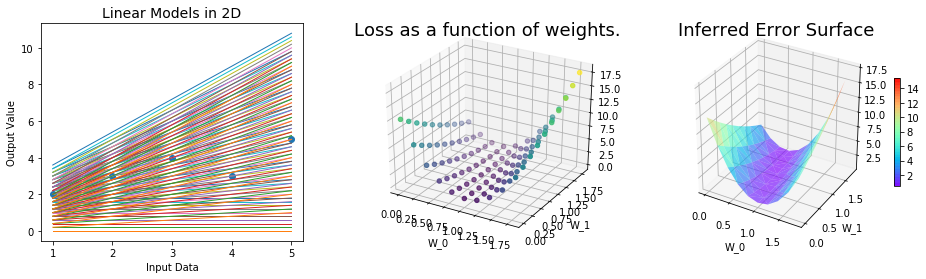

In [109]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
W0_MIN = 0
W0_MAX = 2
W0_STEP = 0.2

W1_MIN = 0
W1_MAX = 2
W1_STEP = 0.2

#################### Grid Search Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### "Training" 
# create a model for each point in our grid
grid = np.mgrid[W0_MIN:W0_MAX:W0_STEP,W1_MIN:W1_MAX:W1_STEP]
size = int(np.product(grid.shape)/2)
models = grid.reshape(2,size).T
# compute loss for each model
loss = []
for W in models:
    loss.append(linRegFunc.OLSLoss(X,y,W))
    
### Display Results
print ("Searched %s models..." %(size))
print ("Best model: %s, Loss: %s" % (models[np.argmin(loss)], min(loss)))
helperFunc.plotErrorSurface(points,models,loss)

> __DISCUSSION QUESTIONS:__ 
* _When we think about scaling up, is this still a better approach than guessing? How could it be parallelized?_ 
* _What would change about this approach if we had higher dimension data?_
* _In practice, when we're training Linear Models why don't we just look at the error surface and identify the lowest point?_
* _What about if we're training other kinds of models?_  

<a id=TL1></a>
## Parameter Space, Gradients, and Convexity

As suggested by the [systematic search demo](#demo2), when we train parametric models we tend to switch back and forth between two different ways of visualizing our goal.

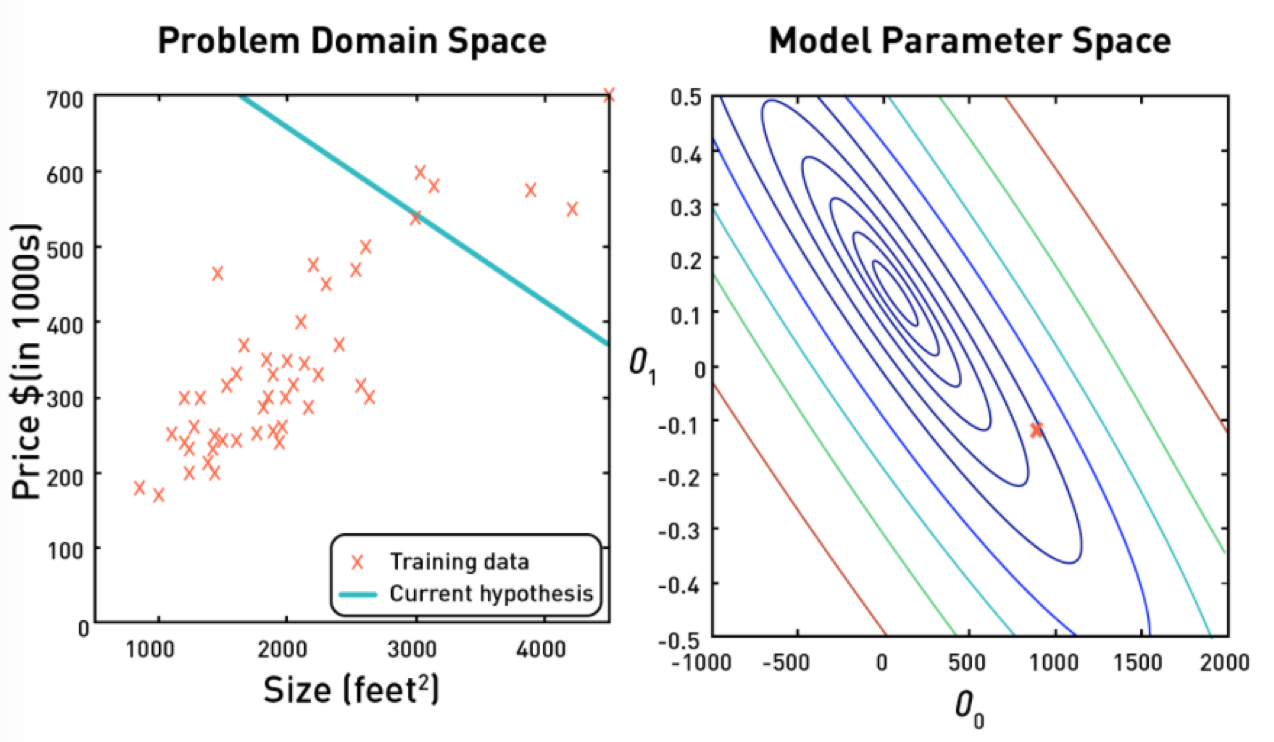

In [110]:
Image(filename="domain_vs_parameter_space.png", width="400", height="400")

* When we look at a model next to our data represented in the Problem Domain Space, it is natural to think about loss as a measure of _**how far off the data are from our model**_. In other words, this visual suggests loss is a function of the training data $X$.
* By contrast, looking at an error surface plotted in Model Parameter Space, we intuitively see loss as an indicator of _**how far off the current model is from the optimal model**_. In other words, this view helps us think of loss as a function of the parameters $\theta$.

Of course in one sense, this distinction is just a matter of sematics. As we saw in equations 1.2, 1.3 and 1.4, MSE loss depends on _both_ the data and the parameters. However, in the context of 'inventing' ways to train a model, this distinction is a useful one. If we think of the data as fixed and focus on how loss varies _with respect to the parameters_, then we can take advantage of a little theory to speed up our search for the optimal parameters.

__Optimization Theory__

Calculus gives us the simple solution to optimizing a real function. The **First Order Conditions** (a.k.a. 'first derivative rule') says that the maximum or minimum of an unconstrained function must occur at a point where the first derivative = 0. In higher dimensions we extend this rule to talk about a **gradient** vector of partial derivatives which all must equal 0. 

When the first order partial derivatives are equal to zero, then we know we are at a local maximum or minimum of the real function.  But which one is it?  In order to tell, we must take the second derivatives of the real function.  If the second derivatives are positive at that point, then we know we are at a minimum.  If the second derivatives are negative, then we know we are at a maximum.  These are the **second order conditions.**

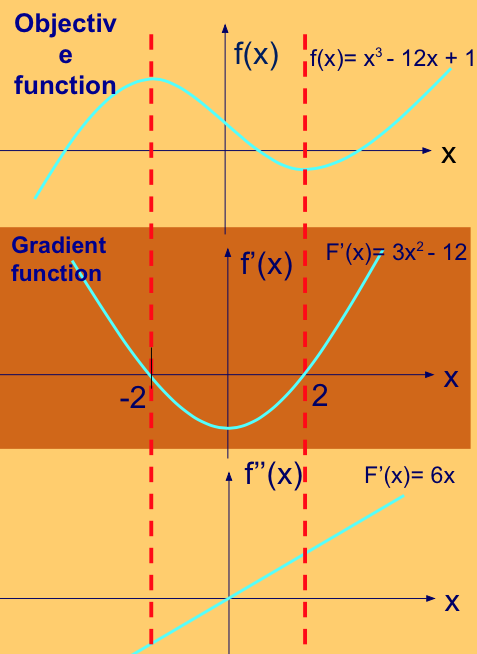

In [111]:
Image(filename="optimization.png", width="250", height="500")

__Convex Optimization__ is the lucky case where we know that the second derivatives never change sign. There are lots of complicated loss functions for which we can't easily visualize the error surface but for which we _can_ prove mathematically that this 2nd order condition is met. If this is the case, then we can think of the suface as _always curving up_ or _always curving down_ which guarantees that any minimum we reach will be an absolute minimum. 

> __DSICUSSION QUESTIONS:__ 
* _In the case of Linear Regression performed on data $X \in \mathbb{R}^m$, how many dimensions does the gradient vector have? What do each of the values in this vector represent visually?_
* _If we are systematically searching the parameter space for a lowest point, why might it be useful to know that our loss function is convex?_ 
* _In general (i.e. beyond Linear Regression) if finding the ideal parameters $\theta$, is as simple as solving the equation $f'(\theta)=0$, why don't we always train our models by solving that equation?_ 

<a id=demo3></a>
## Demo: Gradient Descent
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

To take advantage of these lessons from Optimization Theory, we'll start by taking the derivative of the loss function with respect to the parameters $\boldsymbol{\theta}$. Recall the matrix formulation of our loss function:

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

We can apply the sum and chain derivation rules to compute the gradient:

\begin{equation}\tag{3.1}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'
\end{equation}

We _could_ now set this equation equal to $0$ and then solve for $\boldsymbol{\theta}$... but it turns out that this __closed form solution__ can be computationally challenging in higher dimensions. It also turns out that a simple approximation technique will work almost as well. 

The strategy of **Gradient Descent** is to start somewhere random in the Model Parameter Space and then move down the error surface to find a minimum point with the optimal parameters for our training data. Its ingeniousness is that we can do this without actually knowing the full shape of the error surface. Think of it like walking down a hill while blindfolded. You test each direction to see which way is down, then take a little step in that direction and repeat the process until you can't feel any more 'down' to go. The 'size' of our steps is controled by a hyperparameter, $\alpha$, the **learning rate**. The whole process can be summarized in 3 steps:
1. Initialize the parameters $\theta$.
2. Compute the gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$.
3. Update the parameters: $\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) $  

We repeat these steps until we reach a stopping criteria.

> __A TASK FOR YOU:__ Compute one Gradent Descent update step for the small example from Part 2. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> For your convenience the augmented input data vectors are already entered in the table below:


Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ |
|:----:|:-----:|:----------------:|:------------------------:|
|  input   | true y   |   predicted y   |  gradient  component for $x_j$       |
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |

The gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$ for this data and these weights is: _______

If $\eta = 0.1$ the update for this step will be: _______

The new parameters will be $\theta_{\text{new}}=$ _______  

 > __DISCUSSION QUESTIONS:__  
 * _How would you go about parallelizing this calculation? What would the mapper do, what would the reducers do? What key-value structure, sorting, partitioning, etc would you use?_ 
 * _How do the computational demands of performing GD compare to the task of computing the loss?_ 

__Run this demo to confirm your hand calculations & examine a few more GD steps.__

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.8 -0.8]
     >>> update: [-0.08 -0.08]
Model 1: [1.08, 0.08]
Loss: 0.7872
     >>> gradient: [ 1.44 -0.16]
     >>> update: [ 0.144 -0.016]
Model 2: [0.94, 0.10]
Loss: 0.791808
     >>> gradient: [-1.632 -0.992]
     >>> update: [-0.1632 -0.0992]
Model 3: [1.10, 0.20]
Loss: 0.82701312
     >>> gradient: [ 2.5536  0.1856]
     >>> update: [ 0.25536  0.01856]
Model 4: [0.84, 0.18]
Loss: 0.9175584768
     >>> gradient: [-3.17568 -1.38368]
     >>> update: [-0.317568 -0.138368]
Model 5: [1.16, 0.32]
Loss: 1.10974407475

Searched 6 models...
Best model: [ 1.08  0.08], Loss: 0.7872


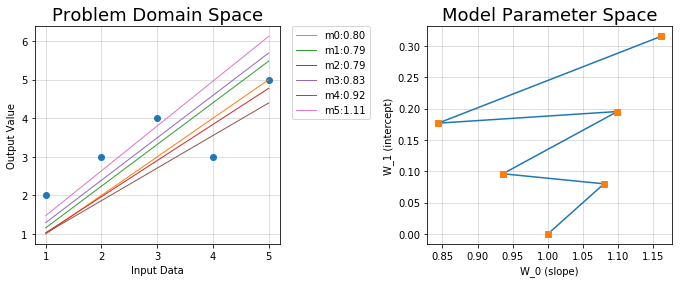

In [112]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = False

################### Gradient Update Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform GD Update & save intermediate model performance
models, loss = linRegFunc.GDUpdate(X, y, N_STEPS,
                                   ORIGINAL_MODEL, 
                                   LEARNING_RATE, 
                                   verbose = True)

### Display Results
print ("\nSearched %s models..." %(len(models)))
print ("Best model: %s, Loss: %s" % (models[np.argmin(loss)], 
                                    loss[np.argmin(loss)]))
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

 > __DISCUSSION QUESTIONS:__  
 * _Look closely at the loss for each model, what problem do you notice?_ 
 * _Use the Model Parameter Space view to explain why this problem might be occurring._ __HINT:__ Try `SHOW_CONTOURS = True`._Based upon your insights, propose a solution to this problem._
 * _When performing GD 'in the wild' will we be able to visualize the error surface (eg. using contour lines, heatmaps or 3D plots)?_

<a id=demo5></a>
## Demo : Stoichastic Gradient Descent
[Return to Contents](#TOC) | [Skip to Appendix](#Appendix)

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

\begin{equation}\tag{3.2}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}

where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

> __A TASK FOR YOU:__ Perform 5 update steps of Stoichastic Gradient Descent with batchsize = $1$ on our small data set. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> ... and we used a learning rate of $\boldsymbol{\eta} = 0.1$

Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\frac{2}{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ | $\eta \nabla_{\boldsymbol{\theta}} f$ | $\boldsymbol(\theta) - \eta \nabla_{\boldsymbol{\theta}} f $ |
|:----:|:-----:|:----------------:|:------------------------:|:--------------:|:-----------:|
|  input   | true y   |   predicted y   | gradient for this 'batch' | update | new parameters|
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             | | |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |  |  |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |  |  |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |

 > __DISCUSSION QUESTIONS:__  
 * _How does this result compare to our result from the hand calculations in the last section? What implications does this have for our quest to find the optimal paramters?_ 
 * _How will parallelizing Stoichastic Gradient Descent be similar/different to parallelizing regular GD?_ 

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.4 -0.4]
     >>> update: [-0.04 -0.04]
Model 1: [1.04, 0.04]
Loss: 0.7648
     >>> gradient: [-1.008 -0.336]
     >>> update: [-0.1008 -0.0336]
Model 2: [1.14, 0.07]
Loss: 0.91414528
     >>> gradient: [ 1.5552   0.31104]
     >>> update: [ 0.15552   0.031104]
Model 3: [0.99, 0.04]
Loss: 0.778215325696
     >>> gradient: [ 1.5737856  0.3934464]
     >>> update: [ 0.15737856  0.03934464]
Model 4: [0.83, 0.00]
Loss: 1.25771068186
     >>> gradient: [-1.07283661 -0.5364183 ]
     >>> update: [-0.10728366 -0.05364183]
Model 5: [0.94, 0.06]
Loss: 0.833767246791

Searched 6 models...
Best model: [ 1.04  0.04], Loss: 0.7648


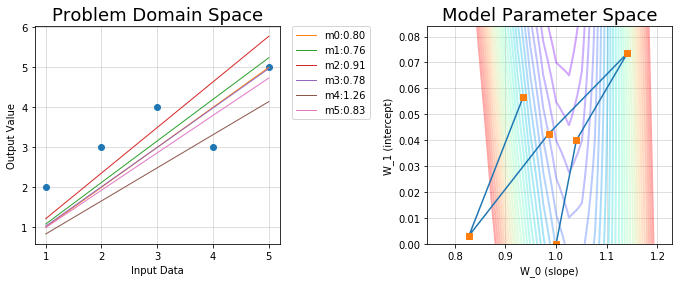

In [113]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
BATCHSIZE = 1
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = True

################### Stoichastic GD Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform SGD Updates & save intermediate model performance
models, loss = linRegFunc.SGDUpdate(X, y, N_STEPS,
                                    BATCHSIZE,
                                    ORIGINAL_MODEL, 
                                    LEARNING_RATE, 
                                    verbose = True)

### Display Results
print ("\nSearched %s models..." %(len(models)))
print ("Best model: %s, Loss: %s" % (models[np.argmin(loss)], 
                                    loss[np.argmin(loss)]))
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

> __DISCUSSION QUESTIONS:__ 
* _At first glance does this seem to work as well as regular gradient descent? Why might our initial impression be deceiving?_ 
* _Does adjusting the batchsize and/or learning rate fix the problem that we're seeing?_
* _What do you notice about the direction of the first 3 updates? From the perspective of the first three points, what should our line look like?_
* _How does the scale of our data can impact the direction of our updates & time to convergence?_

# Dealing with missing data

## Identifying missing values in tabular data

In [114]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [115]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [116]:
# access the underlying NumPy array
# via the `values` attribute
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

<br>
<br>

## Eliminating samples or features with missing values

In [117]:
# remove rows that contain missing values

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [118]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [119]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [120]:
# only drop rows where all columns are NaN

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [121]:
# drop rows that have less than 3 real values 

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [122]:
# only drop rows where NaN appear in specific columns (here: 'C')

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


<br>
<br>

## Imputing missing values

In [123]:
# again: our original array
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

In [124]:
# impute missing values via the column mean

from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

<br>
<br>

## Understanding the scikit-learn estimator API

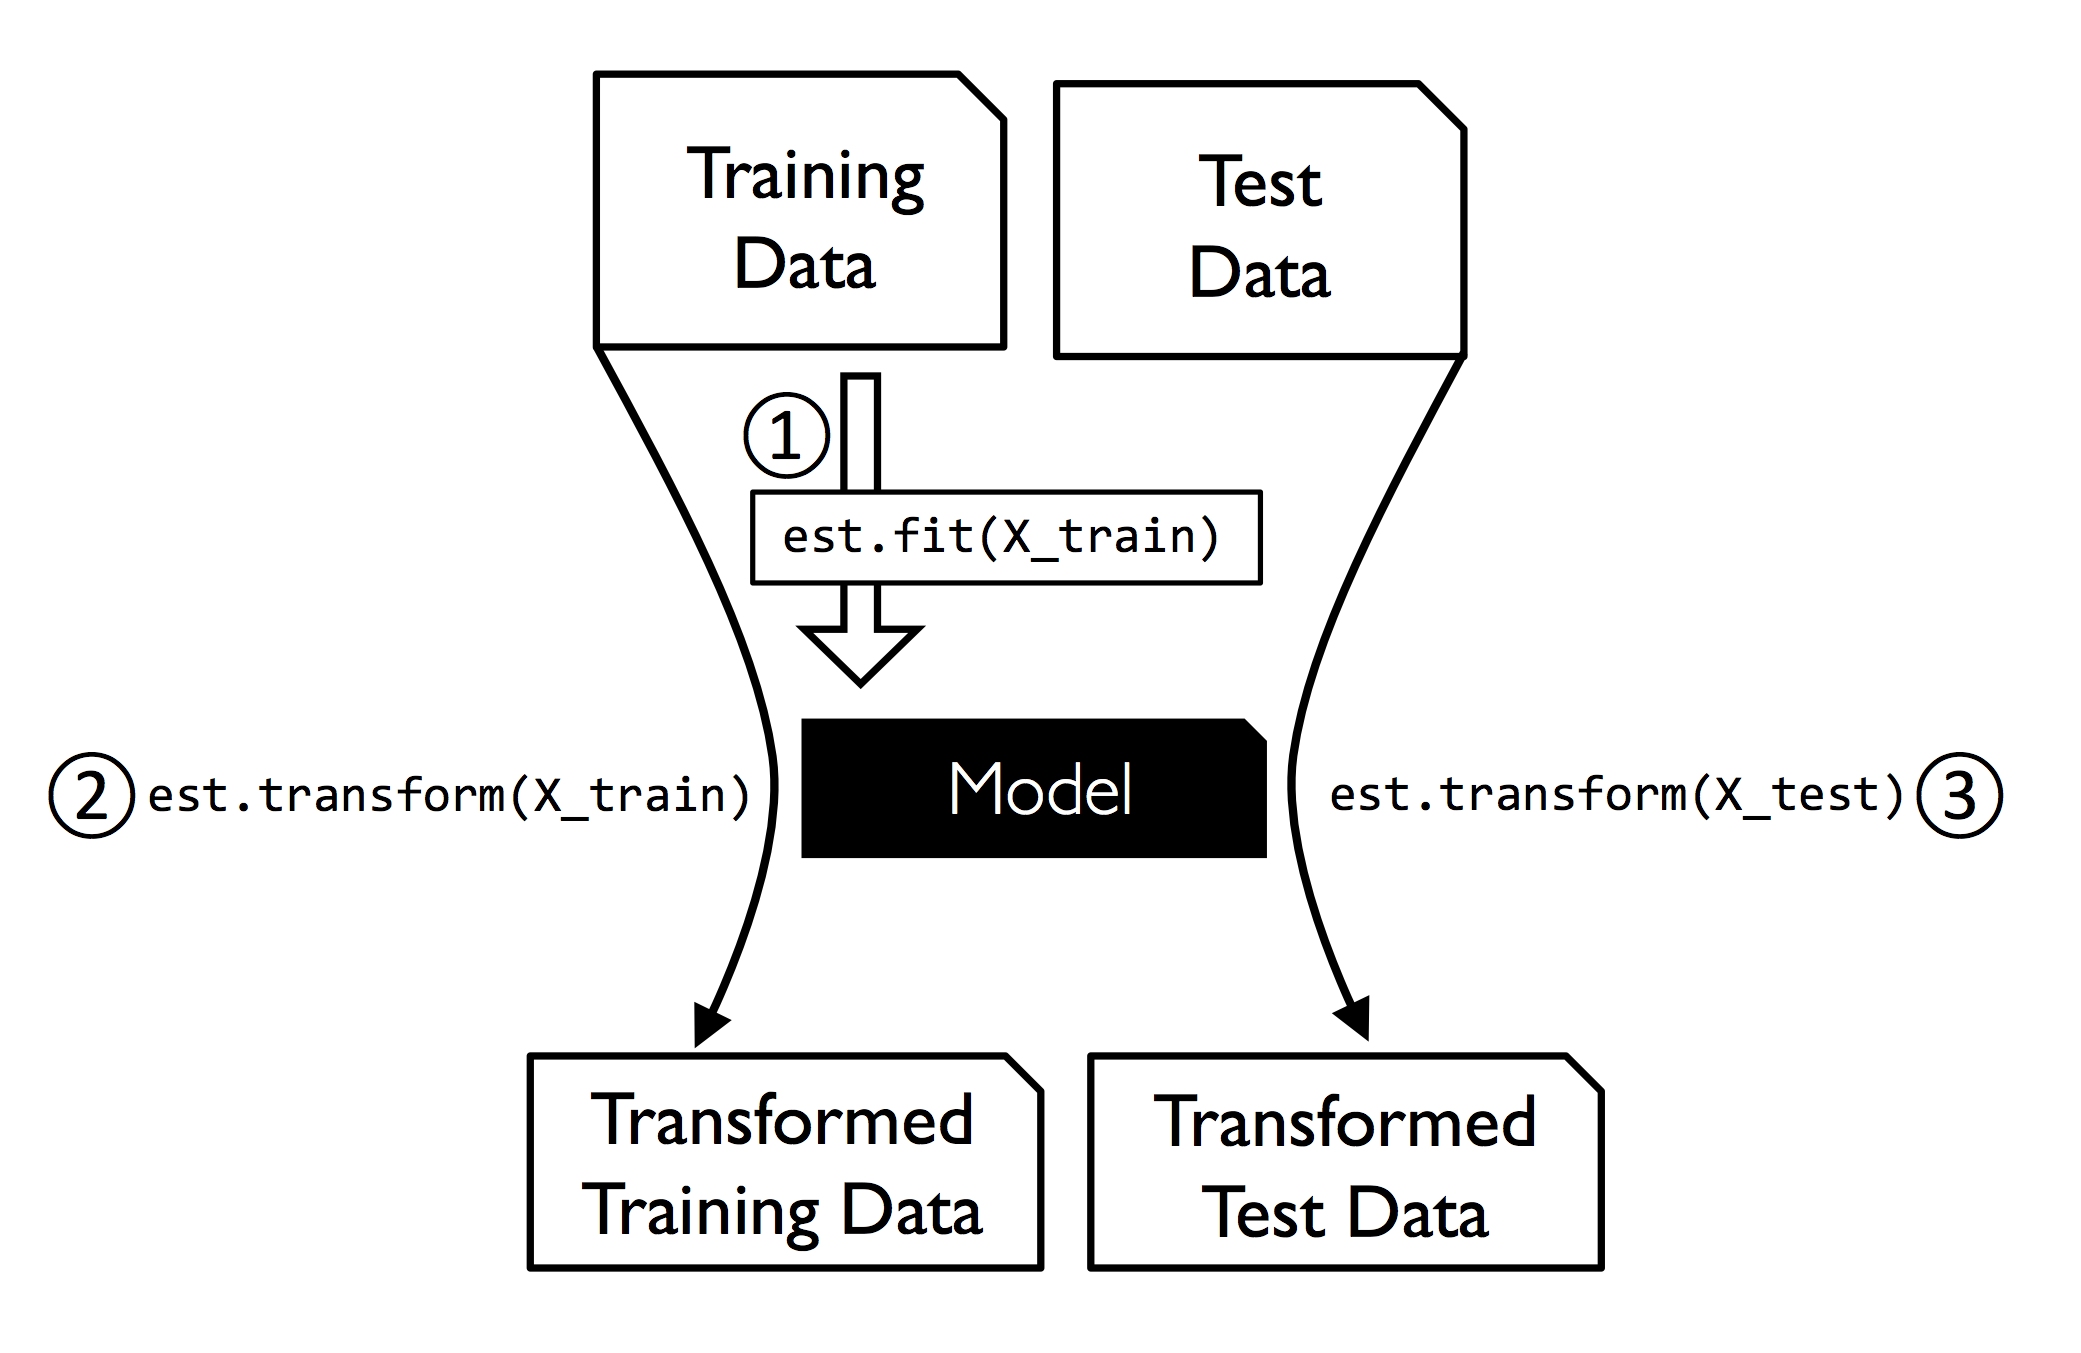

In [125]:
Image(filename='images/04_01.png', width=400) 

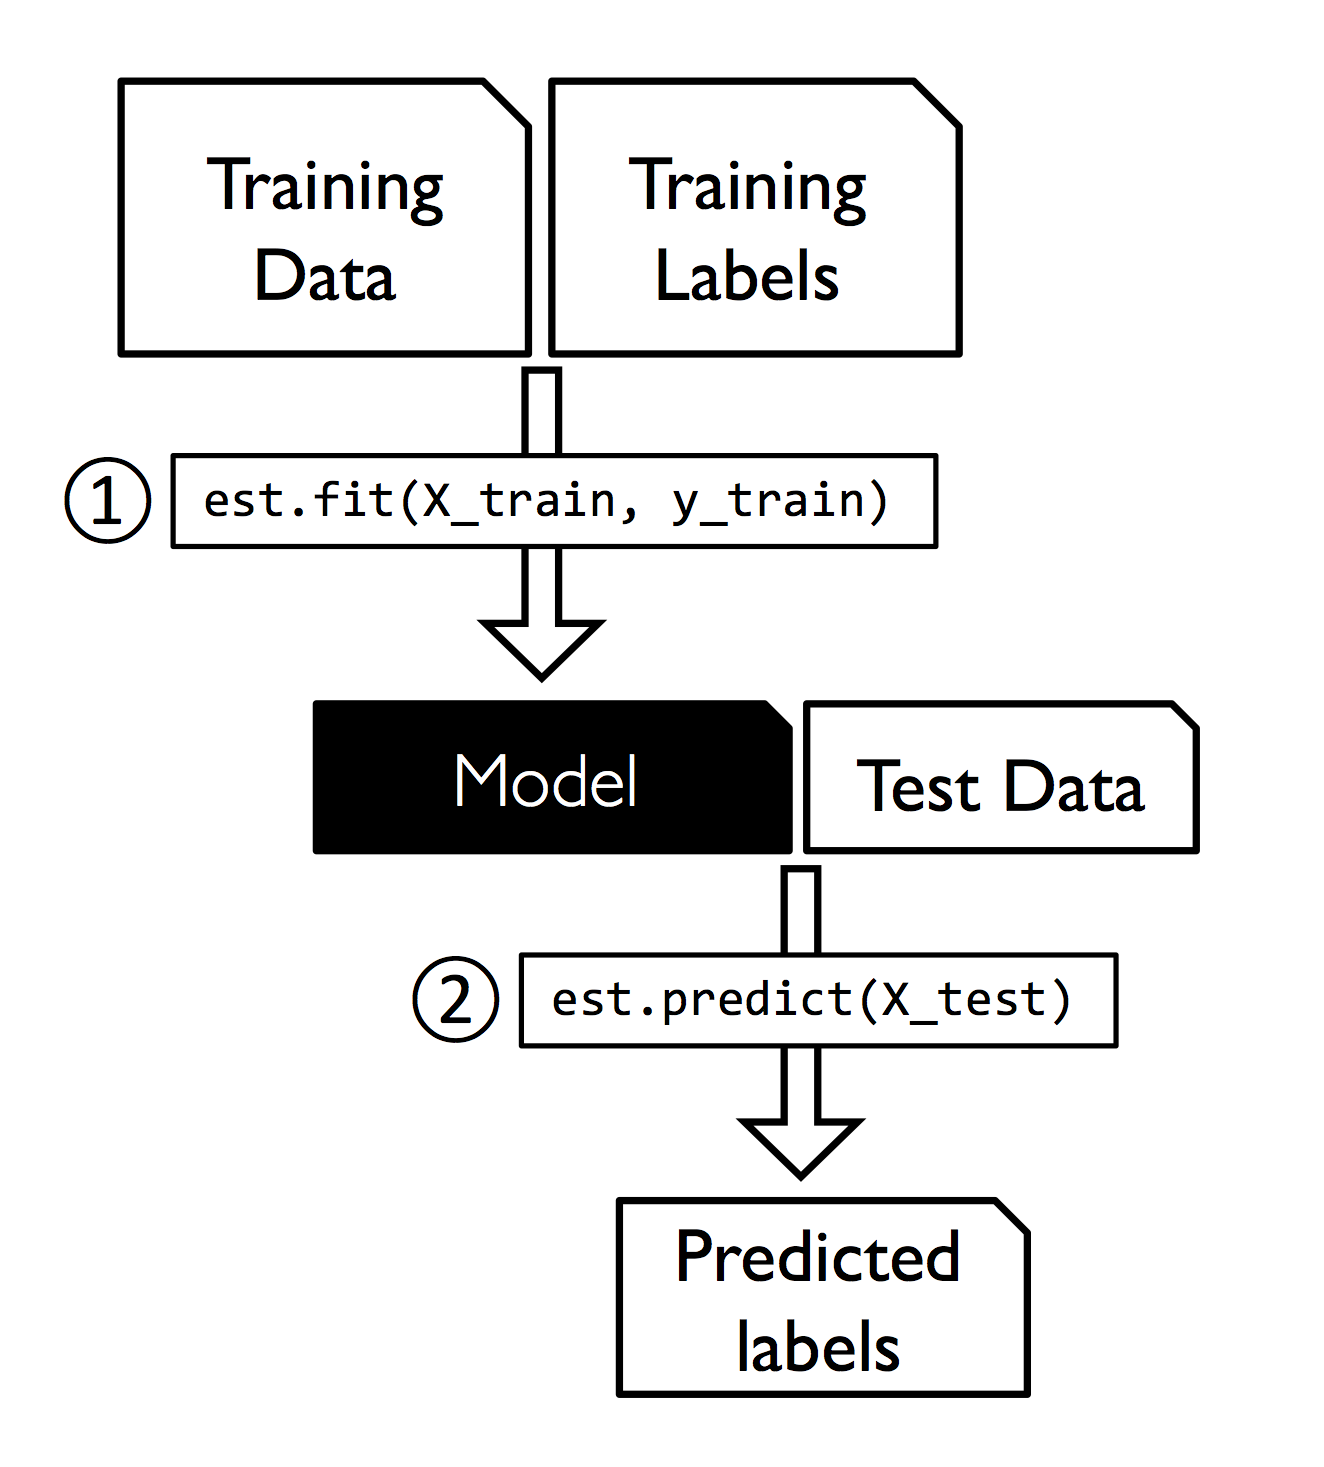

In [126]:
Image(filename='images/04_02.png', width=300) 

<br>
<br>

# Handling categorical data

## Nominal and ordinal features

In [127]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


<br>
<br>

## Mapping ordinal features

In [128]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [129]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>
<br>

## Encoding class labels

In [130]:
import numpy as np

# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [131]:
# to convert class labels from strings to integers
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [132]:
# reverse the class label mapping
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [133]:
from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [134]:
# reverse mapping
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

<br>
<br>

## Performing one-hot encoding on nominal features

In [135]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [136]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [137]:
# return dense array so that we can skip
# the toarray step

ohe = OneHotEncoder(categorical_features=[0], sparse=False)
ohe.fit_transform(X)

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [138]:
# one-hot encoding via pandas

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


### multicollinearity guard in get_dummies
When we are using one-hot encoding datasets, we have to keep in mind that it
introduces multicollinearity, which can be an issue for certain methods (for instance,
methods that require matrix inversion). If features are highly correlated, matrices are
computationally difficult to invert, which can lead to numerically unstable estimates.
To reduce the correlation among variables, we can simply remove one feature
column from the one-hot encoded array. Note that we do not lose any important
information by removing a feature column, though; for example, if we remove the
column color_blue, the feature information is still preserved since if we observe
color_green=0 and color_red=0, it implies that the observation must be blue.

In [139]:
# multicollinearity guard in get_dummies

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [140]:
# multicollinearity guard for the OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

array([[  1. ,   0. ,   1. ,  10.1],
       [  0. ,   1. ,   2. ,  13.5],
       [  0. ,   0. ,   3. ,  15.3]])

<br>
<br>

# Partitioning a dataset into a seperate training and test set

In [141]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [142]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

<br>
<br>

# Bringing features onto the same scale

In [143]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [144]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

A visual example:

In [145]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('standardized:', (ex - ex.mean()) / ex.std())

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [ 0.   0.2  0.4  0.6  0.8  1. ]


<br>
<br>

# Summary

<a id=Appendix></a>
# Appendix: Supporting Code.


This section of the notebook contains the code for the supporting files referenced throughout this notebook. These include:  
* `helperFunc.py` - _functions to create, plot, and transform data_
* `linRegFunc.py` - _functions to run Linear Regression via gradient descent._  

__WARNING: running the cells below will recreate each file and overwrite any existing file of the same name.__

### `helperFunc.py`

In [146]:
%%writefile helperFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)

"""
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def augment(X):
    """
    Takes an np.array whose rows are data points and augments each
    each row with a 1 in the last position to represent the bias.
    """
    return np.insert(X, -1, 1.0, axis=1)


def plot2DModels(data, models=[], names = [], title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data       - numpy array of points x, y
            model_list - [(label,[w_0, w_1]), ...]
            title      - (optional) figure title
    """
    # create plot
    fig, ax = plt.subplots()
    # plot data
    ax.plot(data[:,0], data[:,1],'o')
    domain = [min(data[:,0]), max(data[:,0])]
    # plot models
    for W,label in zip(models, names):
        m , b = W[0], W[1]
        yvals = [m*x + b for x in domain]
        ax.plot(domain, yvals, linewidth=1, label=label)
    if models:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # title & formatting
    if title:
        plt.title(title)
        
def plotErrorSurface(data, weight_grid, loss, title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data    - numpy array of points x, y
            weight_grid  - numpy array of weight vectors [w_0, w_1]
            loss    - list/array of loss corresponding to ^
            title   - (optional) figure title
    """
    # create figure
    fig = plt.figure(figsize=plt.figaspect(0.25))

    # plot data
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(data[:,0], data[:,1],'o')
    ax1.set_title("Linear Models in 2D", fontsize=14)
    plt.xlabel('Input Data')
    plt.ylabel('Output Value')
    domain = [min(data[:,0]), max(data[:,0])]
    
    # plot models
    for idx, W in enumerate(weight_grid):
        m , b = W[0], W[1]
        yvals = [m*x + b for x in domain]
        ax1.plot(domain, yvals, linewidth=1)
        
    # plot loss in 3D
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.set_title("Loss as a function of weights.", fontsize=18)
    plt.xlabel('W_0')
    plt.ylabel('W_1')
    X,Y = weight_grid.T
    ax2.scatter(X,Y,loss, c=loss)
    
    
    # plot error surface in 3D
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.set_title("Inferred Error Surface", fontsize=18)
    plt.xlabel('W_0')
    plt.ylabel('W_1')
    X,Y = weight_grid.T
    surf = ax3.plot_trisurf(X,Y,loss, cmap=cm.rainbow, 
                            linewidths = 2.0, alpha=0.65)
    fig.colorbar(surf, alpha=0.65, shrink = 0.5)
    
    # title & formatting
    if title:
        plt.title(title)

Overwriting helperFunc.py


### `linRegFunc.py`

In [147]:
%%writefile linRegFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains several helper functions for OLS Linear Regression.

Avaliable functions include:
    OLSloss(X, y, model)
    OLSGradient(X, y, model)
    GDUpdate(X, y, nIter, init_model, learning_rate, verbose = False)
    plotGDProgress(data, models, loss, loss_fxn = OLSLoss, show_contours = True)
    SGDUpdate(X, y, B, nIter, init_model, learning_rate, verbose = False)
    mean_absolute_percentage_error(y_true, y_pred)
"""
# general imports
import sys
import csv
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

# custom module import
from helperFunc import augment


def OLSLoss(X, y, model):
    """
    Computes mean squared error for a linear model.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    N = len(X)
    W = np.array(model)
    return 1/float(N) * sum((W.dot(X.T) - y)**2)
    
def OLSGradient(X, y, model):
    """
    Computes the gradient of the OLS loss function for 
    the provided data & linear model.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    N = len(X)
    W = np.array(model)
    return 2.0/N *(W.dot(X.T) - y).dot(X)

def GDUpdate(X, y, nIter, init_model, learning_rate, verbose = False):
    """
    Performs Gradient Descent Updates for linear models using OLS Loss.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            nIter - number of updates to perform
            init_model  - [w_0, w_1] starting coefficient & bias
            learning_rate - step size for the update
            verbose - (optional) printout each update
    OUTPUT: models , loss  - two lists
    """
    # keep track of our progress
    models = [init_model]
    loss = [OLSLoss(X,y,init_model)]
    
    # perform updates
    for idx in range(nIter):
        gradient = OLSGradient(X, y, models[-1])
        update = learning_rate * gradient
        new_model = models[-1] - update
        if verbose:
            print ("Model %s: [%.2f, %.2f]" % (idx, models[-1][0],models[-1][1]),)  
            print ("Loss: %s" % (loss[-1]))
            print ("     >>> gradient: %s" % (gradient,))
            print ("     >>> update: %s" % (update))
        models.append(new_model)
        loss.append(OLSLoss(X,y,new_model))
    if verbose:
            print ("Model %s: [%.2f, %.2f]" % (nIter, models[-1][0],models[-1][1]),)
            print ("Loss: %s" % (loss[-1]))
    return np.array(models), loss


def SGDUpdate(X, y, nIter, B, init_model, learning_rate, verbose = False):
    """
    Performs Stoichastic Gradient Descent Updates for linear models using OLS Loss.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            nIter - number of updates to perform
            B - batchsize (integer)
            init_model  - [w_0, w_1] starting coefficient & bias
            learning_rate - step size for the update
            verbose - (optional) printout each update
    OUTPUT: models , loss  - two lists
    """
    # keep track of our progress
    models = [init_model]
    loss = [OLSLoss(X,y,init_model)]
    
    # perform updates
    n = len(X)
    for idx in range(nIter):
        j = (idx*B)%n # index to start batch
        batch_X, batch_y = X[j:j+B], y[j:j+B]
        gradient = OLSGradient(batch_X, batch_y, models[-1])/n
        update = learning_rate * gradient
        new_model = models[-1] - update
        if verbose:
            print ("Model %s: [%.2f, %.2f]" % (idx, models[-1][0],models[-1][1]),)
            print ("Loss: %s" % (loss[-1]))
            print ("     >>> gradient: %s" % (gradient,))
            print ("     >>> update: %s" % (update))
        models.append(new_model)
        loss.append(OLSLoss(X,y,new_model))
    if verbose:
            print ("Model %s: [%.2f, %.2f]" % (nIter, models[-1][0],models[-1][1]),) 
            print ("Loss: %s" % (loss[-1]))
    return np.array(models), loss


def plotGDProgress(data, models, loss, loss_fxn = OLSLoss, show_contours = True):    
    """
    Plot a set of 2d models for comparison.
    INPUT:  data    - numpy array of points x, y
            models  - numpy array of weight vectors [w_0, w_1]
            loss    - list/array of loss corresponding to ^
            title   - (optional) figure title
    """
    # Create figure w/ two subplots
    fig = plt.figure(figsize=plt.figaspect(0.35))
    ax1 = plt.subplot(1, 2, 1)
    ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2 = plt.subplot(1, 2, 2)
    ax2.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    fig.subplots_adjust(wspace=.6)
    
    ##### Problem Domain Space #####
    
    # plot data
    ax1.plot(data[:,0], data[:,1],'o')
    ax1.set_title("Problem Domain Space", fontsize=18)
    ax1.set_xlabel('Input Data')
    ax1.set_ylabel('Output Value')
    domain = [min(data[:,0]), max(data[:,0])]
    
    # plot models
    for idx, W in enumerate(models):
        m , b = W[0], W[1]
        yvals = [m*x + b for x in domain]
        name = 'm%s:%.2f' %(idx, loss[idx])
        ax1.plot(domain, yvals, label=name, linewidth=1)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ##### Model Parameter Space #####
    
    # plot loss for our models
    w0, w1 = models.T
    ax2.plot(w0,w1)
    ax2.plot(w0,w1, 's')
    ax2.set_title("Model Parameter Space", fontsize=18)
    ax2.set_xlabel('W_0 (slope)')
    ax2.set_ylabel('W_1 (intercept)')
    
    # plot contour lines
    if show_contours:
        # grid parameters -- just a bit larger than models
        w0_min, w0_max= min(w0)*0.9, max(w0)*1.1
        w1_min, w1_max = min(w1)*0.9, max(w1)*1.2
        w0_step = (w0_max - w0_min)/20
        w1_step = (w1_max - w1_min)/20 
        # create loss grid for contour plot
        grid_w0, grid_w1 = np.mgrid[w0_min:w0_max:w0_step,
                                    w1_min:w1_max:w1_step]
        grid_loss = [loss_fxn(augment(data)[:,:2], data[:,1], model)
                     for model in zip(grid_w0.flatten(), grid_w1.flatten())]
        grid_loss = np.array(grid_loss).reshape(20,20)
        # plot loss contours
        topo_levels = np.logspace(min(np.log(min(loss)),0.1), 
                                  min(np.log(max(loss))/10,20))
        CS = ax2.contour(grid_w0, grid_w1, grid_loss, 
                         levels = topo_levels, cmap = 'rainbow', 
                         linewidths = 2.0, alpha=0.35)
    
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100 

Overwriting linRegFunc.py


...